# SKLearn Spacy Reddit Text Classification Example

In this example we will be buiding a text classifier using the reddit content moderation dataset.

For this, we will be using SpaCy for the word tokenization and lemmatization. 

The classification will be done with a Logistic Regression binary classifier.
For more information please visit: https://towardsdatascience.com/real-time-stream-processing-for-machine-learning-at-scale-with-spacy-kafka-seldon-core-6360f2fedbe

The steps in this tutorial include:

1) Train and build your NLP model

2) Build your containerized model

3) Test your model as a docker container

4) Run Seldon in your kubernetes cluster

5) Deploy your model with Seldon

6) Interact with your model through API

7) Clean your environment


## Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* Python 3.6+
* Python DEV requirements (we'll install them below)

Let's get started! 🚀🔥

## 1) Train and build your NLP model

In [1]:
%%writefile requirements.txt
scikit-learn>=0.23.2
spacy==2.3.2
dill==0.3.2
pandas==1.1.1


Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 9.9 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 10.5 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 184 kB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 22.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 11.8 MB/s eta 0:00:01
  Created wheel for dill: filename=dill-0.3.2-py3-none-any.whl size=78911 sha256=bf7905b0c7ccd22cf2a306704d5f408f62c547aa74f023367fee8a77634c4f53
  Stored in directory: /home/nadine/.cache/pip/wheels/72/6b/d5/5548aa1b73b8c3d176ea13f9f92066b02e82141549d90e2100
Successfully built dill
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.0
    Uninstalling pandas-1.1.0:
      Successfully uninstalled pandas-1.1.0


In [1]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 2.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [12]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from seldon_core.seldon_client import SeldonClient
import dill
import sys, os

# This import may take a while as it will download the Spacy ENGLISH model
from ml_utils import CleanTextTransformer, SpacyTokenTransformer

In [13]:
df_cols = ["prev_idx", "parent_idx", "body", "removed"]

TEXT_COLUMN = "body" 
CLEAN_COLUMN = "clean_body"
TOKEN_COLUMN = "token_body"

# Downloading the 50k reddit dataset of moderated comments
df = pd.read_csv("https://raw.githubusercontent.com/axsauze/reddit-classification-exploration/master/data/reddit_train.csv", 
                         names=df_cols, skiprows=1, encoding="ISO-8859-1")

df.head()

,prev_idx,parent_idx,body,removed
0,8756,8877,Always be wary of news articles that cite unpu...,0
1,7330,7432,The problem I have with this is that the artic...,0
2,15711,15944,"This is indicative of a typical power law, and...",0
3,1604,1625,This doesn't make sense. Chess obviously trans...,0
4,13327,13520,1. I dispute that gene engineering is burdenso...,0


<AxesSubplot:>

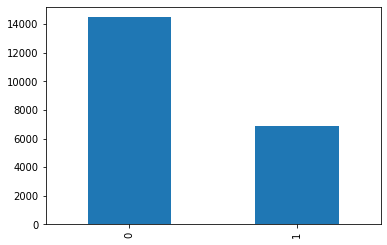

In [14]:
# Let's see how many examples we have of each class
df["removed"].value_counts().plot.bar()

In [15]:
x = df["body"].values
y = df["removed"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, shuffle=True)

In [16]:
# Clean the text
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)

In [17]:
# Tokenize the text and get the lemmas
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)

In [13]:
# Build tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    preprocessor=lambda x: x, 
    tokenizer=lambda x: x, 
    token_pattern=None,
    ngram_range=(1, 3))

tfidf_vectorizer.fit(x_train_tokenized)

TfidfVectorizer(max_features=10000, ngram_range=(1, 3),
                preprocessor=<function <lambda> at 0x7fe61e82f680>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7fe61e82f5f0>)

In [14]:
# Transform our tokens to tfidf vectors
x_train_tfidf = tfidf_vectorizer.transform(x_train_tokenized)

In [15]:
# Train logistic regression classifier
lr = LogisticRegression(C=0.1, solver='sag')
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.1, solver='sag')

In [16]:
# These are the models we'll deploy
with open('tfidf_vectorizer.model', 'wb') as model_file:
    dill.dump(tfidf_vectorizer, model_file)
with open('lr.model', 'wb') as model_file:
    dill.dump(lr, model_file)

## 2) Build your containerized model

In [17]:
%%writefile RedditClassifier.py
import dill

from ml_utils import CleanTextTransformer, SpacyTokenTransformer


class RedditClassifier(object):
    def __init__(self):

        self._clean_text_transformer = CleanTextTransformer()
        self._spacy_tokenizer = SpacyTokenTransformer()

        with open("tfidf_vectorizer.model", "rb") as model_file:
            self._tfidf_vectorizer = dill.load(model_file)

        with open("lr.model", "rb") as model_file:
            self._lr_model = dill.load(model_file)

    def predict(self, X, feature_names):
        clean_text = self._clean_text_transformer.transform(X)
        spacy_tokens = self._spacy_tokenizer.transform(clean_text)
        tfidf_features = self._tfidf_vectorizer.transform(spacy_tokens)
        predictions = self._lr_model.predict_proba(tfidf_features)
        return predictions

Overwriting RedditClassifier.py


In [18]:
# test that our model works
from RedditClassifier import RedditClassifier
# With one sample
sample = x_test[0:1]
print(sample)
print(RedditClassifier().predict(sample, ["feature_name"]))

['This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf']
[[0.82791732 0.17208268]]


### Create Docker Image with the S2i utility
Using the S2I command line interface we wrap our current model to seve it through the Seldon interface

In [3]:
%%writefile Dockerfile
FROM seldonio/seldon-core-s2i-python37-ubi8:1.7.0-dev

RUN pip install spacy==2.3.2
RUN python -m spacy download en_core_web_sm

Overwriting Dockerfile


In [4]:
%%bash
docker build . -f Dockerfile -t seldonio/seldon-core-spacy-base:0.1

#1 [internal] load build definition from Dockerfile
#1 sha256:456ba4fb7975f8c66cb47f5783f3ff34ac4c535a63912c1d27ce72bbe0d63b83
#1 transferring dockerfile: 173B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 sha256:8f400c1990a77c47cbbf40ed397dd023f5b85426e8239c6c07bef77255e0861a
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/seldonio/seldon-core-s2i-python37-ubi8:1.7.0-dev
#3 sha256:0ea020e7a4239d8c0dfab255297ed4513a937f10c4eb4a0da2ede2aa401cf138
#3 DONE 0.0s

#4 [1/3] FROM docker.io/seldonio/seldon-core-s2i-python37-ubi8:1.7.0-dev
#4 sha256:1c0985604a56cce763c19b93669933d75dbdf8b7fc62a5cc9aa635630df6aa28
#4 CACHED

#5 [2/3] RUN pip install spacy==2.3.2
#5 sha256:d050cddbacda288e4faf815fd216ac3fee288c8e13762b13970f0493db32a1ba
#5 0.863 Collecting spacy==2.3.2
#5 0.967   Downloading spacy-2.3.2-cp37-cp37m-manylinux1_x86_64.whl (9.9 MB)
#5 1.612 Collecting blis<0.5.0,>=0.4.0
#5 1.640   Downloading blis-0.4.1-cp37-cp37m-manylinux1_x86_64.wh

To create a docker image we need to create the s2i folder configuration as below:

In [5]:
!cat .s2i/environment

MODEL_NAME=RedditClassifier
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


In [6]:
# As well as a requirements.txt file with all the relevant dependencies
!cat requirements.txt

scikit-learn>=0.23.2
spacy==2.3.2
dill==0.3.2
pandas==1.1.1


In [7]:
%%bash
s2i build . seldonio/seldon-core-spacy-base:0.1 seldonio/reddit-classifier:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Created wheel for dill: filename=dill-0.3.2-py3-none-any.whl size=78912 sha256=484ab95ec424c23e0b5d0e92279e0dd99d7b5c337ab85d7a926596cc0028b947
Stored in directory: /tmp/pip-ephem-wheel-cache-3emqefhy/wheels/72/6b/d5/5548aa1b73b8c3d176ea13f9f92066b02e82141549d90e2100
Successfully built dill
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Created wheel for PTable: filename=PTable-0.9.2-py3-none-any.whl size=22907 sha256=8475610d2b71640b1d3866997bd82d7de2ccb5ed12de195ddc11a8f1dc05a75f
Stored in directory: /root/.cache/pip/wheels/33/df/2f/674985b3f8a2de3f96357d1eadef5110f74fa91b3785e52a54
Successfully built PTable
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
created path: ./licenses/license_info.csv
created path: ./licenses/license.txt
Build completed successfully


## 3) Test your model as a docker container

In [8]:
# Remove previously deployed containers for this model
!docker rm -f reddit_predictor

Error: No such container: reddit_predictor


In [21]:
!docker run --name "reddit_predictor" -d --rm -p 9001:9000 seldonio/reddit-classifier:0.1

d594705a8a21e8d8994af0b24e28b3c1510e9050fa5c24146eeaac55f496f73e


In [24]:
!curl -v -X POST -H 'Content-Type: application/json' \
   -d '{"data": { "ndarray": ["this is a terrible comment"], "names": ["tfidf"] } }' \
    http://localhost:9001/api/v1.0/predictions

Note: Unnecessary use of -X or --request, POST is already inferred.
*   Trying 127.0.0.1:9001...
* TCP_NODELAY set
* Connected to localhost (127.0.0.1) port 9001 (#0)







* upload completely sent off: 76 out of 76 bytes
* Mark bundle as not supporting multiuse








{"data":{"names":["t:0","t:1"],"ndarray":[[0.535398662890584,0.46460133710941603]]},"meta":{}}
* Connection #0 to host localhost left intact


In [23]:
# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:9001"
batch = sample
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)
response = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

print(response)

Success:True message:
Request:
data {
  names: "tfidf"
  ndarray {
    values {
      string_value: "This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf"
    }
  }
}

Response:
meta {
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.8279173241631921
        }
        values {
          number_value: 0.1720826758368079
        }
      }
    }
  }
}



In [25]:
# We now stop it to run it in docker
!docker stop reddit_predictor

reddit_predictor


## 4) Run Seldon in your kubernetes cluster


## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) or Istio and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

## 5) Deploy your model with Seldon
We can now deploy our model by using the Seldon graph definition:

In [26]:
%%writefile reddit_clf.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "reddit-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Reddit classifier",
            "deployment_version": "v1"
        },
        "name": "reddit-classifier",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/reddit-classifier:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                        ],
                        "terminationGracePeriodSeconds": 20
                    }
                }],
                "graph": {
                    "children": [],
                    "name": "classifier",
                    "endpoint": {
            "type" : "REST"
            },
                    "type": "MODEL"
                },
                "name": "single-model",
                "replicas": 1,
        "annotations": {
            "predictor_version" : "v1"
        }
            }
        ]
    }
}

Overwriting reddit_clf.json


Note: if you are using kind preload image first with
```bash
kind load docker-image reddit-classifier:0.1 --name <name of your cluster>
```

In [40]:
!kubectl apply -f reddit_clf.json

seldondeployment.machinelearning.seldon.io/reddit-classifier unchanged


In [28]:
!kubectl get pods 

NAME                                                           READY   STATUS    RESTARTS   AGE
reddit-classifier-single-model-0-classifier-78d5cf779d-btxqg   2/2     Running   0          27s
seldon-92a927e5e90d7602e08ba9b9304f70e8-5bcf96696f-6pwbt       1/2     Running   2          2d23h


## 6) Interact with your model through API
Now that our Seldon Deployment is live, we are able to interact with it through its API.

There are two options in which we can interact with our new model. These are:

a) Using CURL from the CLI (or another rest client like Postman)

b) Using the Python SeldonClient

#### a) Using CURL from the CLI

In [41]:
%%bash
curl -v -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": ["Hello world this is a test"]}}' \
    http://localhost:80/seldon/default/reddit-classifier/api/v1.0/predictions

{"data":{"names":["t:0","t:1"],"ndarray":[[0.6811752552555037,0.3188247447444963]]},"meta":{"requestPath":{"classifier":"seldonio/reddit-classifier:0.1"}}}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:80...
* TCP_NODELAY set
* Connected to localhost (127.0.0.1) port 80 (#0)
> POST /seldon/default/reddit-classifier/api/v1.0/predictions HTTP/1.1
> Host: localhost
> User-Agent: curl/7.68.0
> Accept: */*
> Content-Type: application/json
> Content-Length: 72
> 
} [72 bytes data]
* upload completely sent off: 72 out of 72 bytes
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< access-control-allow-headers: Accept, Accept-Encoding, Authorization, Content-Length, Content-Type, X-CSRF-Token
< access-control-allow-methods: OPTIONS,POST
< access-control-allow-origin: *
< content-type: application/json
< seldon-puid: 7b586b15-2a7a-4d36-aa39-210b24cb5841
< x-content-type-options: nosniff
< date: Fri, 19 Mar 2021 09:47:09 GMT
< conte

#### b) Using the Python SeldonClient

In [42]:
from seldon_core.seldon_client import SeldonClient
import numpy as np

sc = SeldonClient(
    gateway="ambassador", 
    transport="rest",
    gateway_endpoint="localhost:80",   # Make sure you use the port above
    namespace="default"
)

client_prediction = sc.predict(
    data=np.array(["Hello world this is a test"]), 
    deployment_name="reddit-classifier",
    names=["text"],
    payload_type="ndarray",
)

print(client_prediction)

Success:True message:
Request:
meta {
}
data {
  names: "text"
  ndarray {
    values {
      string_value: "Hello world this is a test"
    }
  }
}

Response:
{'data': {'names': ['t:0', 't:1'], 'ndarray': [[0.6811752552555037, 0.3188247447444963]]}, 'meta': {'requestPath': {'classifier': 'seldonio/reddit-classifier:0.1'}}}


## 7) Clean your environment

In [45]:
!kubectl delete -f reddit_clf.json

seldondeployment.machinelearning.seldon.io "reddit-classifier" deleted
